In [17]:
from google.colab import files
uploaded = files.upload()  # upload Data.zip



Saving Data.zip to Data (1).zip


In [18]:
import zipfile
with zipfile.ZipFile("Data.zip", 'r') as z:
    z.extractall("data")


In [19]:
!pip install numpy pandas matplotlib torch torchvision torchaudio tqdm hmmlearn



In [20]:
# load_data.py
import zipfile, os
from collections import Counter

DATA_ZIP = "/mnt/data/Data.zip"   # adjust if needed
OUT_DIR = "/mnt/data/data_extracted"

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

# unzip if needed
if os.path.exists(DATA_ZIP):
    with zipfile.ZipFile(DATA_ZIP, 'r') as z:
        z.extractall(OUT_DIR)

# look for corpus.txt
candidates = []
for root,_,files in os.walk(OUT_DIR):
    for f in files:
        if f.lower().startswith("corpus") and f.lower().endswith(".txt"):
            candidates.append(os.path.join(root,f))

if not candidates:
    # maybe corpus is in /mnt/data
    if os.path.exists("/mnt/data/corpus.txt"):
        candidates = ["/mnt/data/corpus.txt"]

print("Found corpus files:", candidates)


Found corpus files: []


In [21]:
# hmm_oracle_ngram.py
import numpy as np
from collections import defaultdict, Counter
import re

class HMMOracleNgram:
    def __init__(self, corpus_path, ngram=3):
        self.ngram = ngram
        self.words = []
        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                w = line.strip().lower()
                if re.fullmatch(r"[a-z]+", w):
                    self.words.append(w)
        # Precompute position-based counts and ngrams
        self.alpha = 'abcdefghijklmnopqrstuvwxyz'
        self.pos_counts = defaultdict(Counter)  # pos -> letter counts
        self.len_buckets = defaultdict(list)
        for w in self.words:
            L = len(w)
            self.len_buckets[L].append(w)
            for i,ch in enumerate(w):
                self.pos_counts[(L,i)][ch] += 1
        # n-gram counts for context predictions
        self.ngram_counts = Counter()
        for w in self.words:
            padded = (' '*(ngram-1)) + w + (' '*(ngram-1))
            for i in range(len(padded)-ngram+1):
                gram = padded[i:i+ngram]
                if ' ' not in gram:  # only pure letters grams
                    self.ngram_counts[gram] += 1

    def candidate_filter(self, pattern):
        # pattern: string like "_a__e" lowercase or underscores
        L = len(pattern)
        candidates = self.len_buckets.get(L, [])
        out = []
        for w in candidates:
            ok = True
            for i,ch in enumerate(pattern):
                if ch != '_' and ch != w[i]:
                    ok = False
                    break
            if ok:
                out.append(w)
        return out

    def letter_prob(self, pattern, guessed=set()):
        # return probability vector for a-z given pattern and guessed letters
        candidates = self.candidate_filter(pattern)
        alpha = self.alpha
        scores = Counter()
        if not candidates:
            # fallback: use position-based distribution across all words of same length
            L = len(pattern)
            for i,ch in enumerate(pattern):
                if ch == '_':
                    counts = self.pos_counts.get((L,i), Counter())
                    for a,count in counts.items():
                        if a not in guessed:
                            scores[a] += count
        else:
            # count letter frequency at blank positions among candidates, weighted
            for w in candidates:
                for i,ch in enumerate(pattern):
                    if ch == '_':
                        c = w[i]
                        if c not in guessed:
                            scores[c] += 1
        # smooth and normalize
        prob = np.ones(26) * 1e-3
        for i,a in enumerate(alpha):
            prob[i] += scores[a]
        prob = prob / prob.sum()
        return {a: prob[i] for i,a in enumerate(alpha)}


In [22]:
# hangman_env.py
import random
import numpy as np

class HangmanEnv:
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.alpha = 'abcdefghijklmnopqrstuvwxyz'

    def reset(self, word=None):
        if word is None:
            self.target = random.choice(self.word_list)
        else:
            self.target = word
        self.lives = self.max_lives
        self.guessed = set()
        self.done = False
        self._update_mask()
        return self._get_state()

    def _update_mask(self):
        self.mask = ''.join([c if c in self.guessed else '_' for c in self.target])

    def _get_state(self):
        # Return masked word, guessed set, lives left
        return {'mask': self.mask, 'guessed': set(self.guessed), 'lives': self.lives}

    def step(self, letter):
        # letter: 'a'..'z'
        if self.done:
            raise ValueError("Game finished")
        reward = 0.0
        info = {}
        if letter in self.guessed:
            reward = -2.0  # penalty for repeated guess
            self.lives -= 0  # keep lives same
            repeated = True
        else:
            self.guessed.add(letter)
            repeated = False
            if letter in self.target:
                # reward for revealing letters (proportional to letters revealed)
                revealed = sum(1 for c in self.target if c == letter)
                reward = 1.0 * revealed
            else:
                self.lives -= 1
                reward = -1.0

        self._update_mask()
        if '_' not in self.mask:
            self.done = True
            reward += 10.0  # big win reward
            info['result'] = 'win'
        elif self.lives <= 0:
            self.done = True
            reward -= 10.0  # losing penalty
            info['result'] = 'lose'

        return self._get_state(), reward, self.done, info


In [23]:
# dqn_agent.py
import random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple

Transition = namedtuple('Transition', ('state_vec', 'action', 'reward', 'next_state_vec', 'done'))

class DQNNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, input_dim, n_actions, lr=1e-4, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=20000,
                 device='cpu'):
        self.device = device
        self.n_actions = n_actions
        self.policy_net = DQNNet(input_dim, n_actions).to(device)
        self.target_net = DQNNet(input_dim, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        self.replay = deque(maxlen=20000)
        self.batch_size = 64
        self.loss_fn = nn.MSELoss()

    def select_action(self, state_vec, valid_actions_mask):
        self.steps_done += 1
        eps_threshold = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                        math.exp(-1. * self.steps_done / self.epsilon_decay)
        if random.random() < eps_threshold:
            # random valid action
            valid_indices = [i for i,v in enumerate(valid_actions_mask) if v==1]
            return random.choice(valid_indices)
        else:
            with torch.no_grad():
                s = torch.tensor(state_vec, dtype=torch.float32, device=self.device).unsqueeze(0)
                qvals = self.policy_net(s).squeeze(0).cpu().numpy()
                # mask invalid actions (already guessed)
                masked = np.copy(qvals) - (1 - np.array(valid_actions_mask))*1e6
                return int(np.argmax(masked))

    def push(self, *args):
        self.replay.append(Transition(*args))

    def sample(self):
        batch = random.sample(self.replay, min(self.batch_size, len(self.replay)))
        return Transition(*zip(*batch))

    def update(self):
        if len(self.replay) < 1000:
            return None
        batch = self.sample()
        state = torch.tensor(np.stack(batch.state_vec), dtype=torch.float32, device=self.device)
        action = torch.tensor(batch.action, dtype=torch.long, device=self.device).unsqueeze(1)
        reward = torch.tensor(batch.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_state = torch.tensor(np.stack(batch.next_state_vec), dtype=torch.float32, device=self.device)
        done = torch.tensor(batch.done, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values = self.policy_net(state).gather(1, action)
        next_q = self.target_net(next_state).max(1)[0].detach().unsqueeze(1)
        expected_q = reward + (1 - done) * self.gamma * next_q

        loss = self.loss_fn(q_values, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [24]:
# state_utils.py
import numpy as np
ALPHA = 'abcdefghijklmnopqrstuvwxyz'

def mask_to_onehot(mask, Lmax=15):
    # mask: string like '_a__e'
    vec = np.zeros((Lmax,26), dtype=np.float32)
    for i,ch in enumerate(mask[:Lmax]):
        if ch != '_':
            idx = ALPHA.index(ch)
            vec[i, idx] = 1.0
    return vec.flatten()

def guessed_to_binary(guessed):
    b = np.zeros(26, dtype=np.float32)
    for g in guessed:
        if g in ALPHA:
            b[ALPHA.index(g)] = 1.0
    return b

def build_state_vector(mask, guessed, lives, oracle_probs, Lmax=15):
    a = mask_to_onehot(mask, Lmax)
    b = guessed_to_binary(guessed)
    c = np.array([lives/6.0], dtype=np.float32)
    d = np.array([oracle_probs[ch] for ch in ALPHA], dtype=np.float32)
    return np.concatenate([a, b, c, d])


In [25]:
import random, time
import numpy as np
from tqdm import trange
import torch

# (no import from hangman_env etc.)

# from hangman_env import HangmanEnv
# from hmm_oracle_ngram import HMMOracleNgram
# from dqn_agent import DQNAgent
# from state_utils import build_state_vector, ALPHA

# Define utility functions directly
ALPHA = 'abcdefghijklmnopqrstuvwxyz'

def mask_to_onehot(mask, Lmax=15):
    # mask: string like '_a__e'
    vec = np.zeros((Lmax,26), dtype=np.float32)
    for i,ch in enumerate(mask[:Lmax]):
        if ch != '_':
            idx = ALPHA.index(ch)
            vec[i, idx] = 1.0
    return vec.flatten()

def guessed_to_binary(guessed):
    b = np.zeros(26, dtype=np.float32)
    for g in guessed:
        if g in ALPHA:
            b[ALPHA.index(g)] = 1.0
    return b

def build_state_vector(mask, guessed, lives, oracle_probs, Lmax=15):
    a = mask_to_onehot(mask, Lmax)
    b = guessed_to_binary(guessed)
    c = np.array([lives/6.0], dtype=np.float32)
    d = np.array([oracle_probs[ch] for ch in ALPHA], dtype=np.float32)
    return np.concatenate([a, b, c, d])


# Paths
CORPUS = "/content/data/Data/corpus.txt"  # adjust
# hyperparams
Lmax = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# load corpus words (clean)
words = []
with open(CORPUS, 'r', encoding='utf-8') as f:
    for line in f:
        w = line.strip().lower()
        if w.isalpha() and len(w) <= Lmax:
            words.append(w)

# instantiate components
oracle = HMMOracleNgram(CORPUS)
env = HangmanEnv(words, max_lives=6)
input_dim = Lmax*26 + 26 + 1 + 26
agent = DQNAgent(input_dim, n_actions=26, device=device)

# training settings
episodes = 20000
sync_every = 1000
print_every = 200
rewards_per_ep = []
losses = []
from collections import deque
recent_rewards = deque(maxlen=100)

for ep in trange(episodes):
    state = env.reset()
    mask = state['mask']
    guessed = state['guessed']
    lives = state['lives']
    oracle_probs = oracle.letter_prob(mask, guessed)
    state_vec = build_state_vector(mask, guessed, lives, oracle_probs, Lmax=Lmax)

    total_reward = 0.0
    done = False
    step = 0
    while not done and step < 26:
        # valid actions mask: 1 if not guessed
        valid_mask = [0]*26
        for i,ch in enumerate(ALPHA):
            if ch not in guessed:
                valid_mask[i] = 1
        action_idx = agent.select_action(state_vec, valid_mask)
        action_letter = ALPHA[action_idx]

        next_state, r, done, info = env.step(action_letter)
        total_reward += r

        next_oracle = oracle.letter_prob(next_state['mask'], next_state['guessed'])
        next_state_vec = build_state_vector(next_state['mask'], next_state['guessed'], next_state['lives'], next_oracle, Lmax=Lmax)

        agent.push(state_vec, action_idx, r, next_state_vec, float(done))
        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        state_vec = next_state_vec
        guessed = next_state['guessed']
        step += 1

    rewards_per_ep.append(total_reward)
    recent_rewards.append(total_reward)

    if ep % sync_every == 0:
        agent.sync_target()
    if ep % print_every == 0 and ep>0:
        print(f"Ep {ep} | recent avg reward {np.mean(recent_rewards):.3f} | replay {len(agent.replay)} | loss {np.mean(losses[-100:]) if losses else None}")

# Save model
torch.save(agent.policy_net.state_dict(), "dqn_policy.pth")
print("Training complete. Model saved.")

  1%|          | 203/20000 [00:26<33:46,  9.77it/s]

Ep 200 | recent avg reward -12.660 | replay 1754 | loss 8.926764087677002


  2%|▏         | 401/20000 [00:50<30:03, 10.87it/s]

Ep 400 | recent avg reward -12.020 | replay 3500 | loss 5.831649034023285


  3%|▎         | 602/20000 [01:15<38:40,  8.36it/s]

Ep 600 | recent avg reward -12.590 | replay 5255 | loss 4.701386234760284


  4%|▍         | 802/20000 [01:40<34:26,  9.29it/s]

Ep 800 | recent avg reward -11.830 | replay 7092 | loss 3.9230357921123504


  5%|▌         | 1002/20000 [02:03<36:45,  8.62it/s]

Ep 1000 | recent avg reward -11.440 | replay 8947 | loss 4.042694308757782


  6%|▌         | 1202/20000 [02:25<32:05,  9.76it/s]

Ep 1200 | recent avg reward -10.830 | replay 10813 | loss 3.499806171655655


  7%|▋         | 1402/20000 [02:50<39:16,  7.89it/s]

Ep 1400 | recent avg reward -8.340 | replay 12816 | loss 3.2705323576927183


  8%|▊         | 1602/20000 [03:14<34:02,  9.01it/s]

Ep 1600 | recent avg reward -9.220 | replay 14800 | loss 3.0676440095901487


  9%|▉         | 1801/20000 [03:37<45:30,  6.67it/s]

Ep 1800 | recent avg reward -7.010 | replay 16840 | loss 3.0664550948143003


 10%|█         | 2002/20000 [04:01<34:31,  8.69it/s]

Ep 2000 | recent avg reward -7.850 | replay 18888 | loss 3.183931517601013


 11%|█         | 2202/20000 [04:26<35:25,  8.37it/s]

Ep 2200 | recent avg reward -2.260 | replay 20000 | loss 3.8612052607536316


 12%|█▏        | 2402/20000 [04:50<33:10,  8.84it/s]

Ep 2400 | recent avg reward -1.550 | replay 20000 | loss 3.5957817387580873


 13%|█▎        | 2602/20000 [05:15<34:51,  8.32it/s]

Ep 2600 | recent avg reward -2.300 | replay 20000 | loss 3.5351417410373687


 14%|█▍        | 2803/20000 [05:40<32:34,  8.80it/s]

Ep 2800 | recent avg reward 2.800 | replay 20000 | loss 3.335641843080521


 15%|█▌        | 3002/20000 [06:08<48:13,  5.88it/s]

Ep 3000 | recent avg reward 2.170 | replay 20000 | loss 3.0633239257335663


 16%|█▌        | 3202/20000 [06:33<44:42,  6.26it/s]

Ep 3200 | recent avg reward 1.830 | replay 20000 | loss 4.675548298358917


 17%|█▋        | 3402/20000 [06:59<40:52,  6.77it/s]

Ep 3400 | recent avg reward 2.970 | replay 20000 | loss 4.043567786216736


 18%|█▊        | 3601/20000 [07:25<36:08,  7.56it/s]

Ep 3600 | recent avg reward 8.420 | replay 20000 | loss 3.4880210876464846


 19%|█▉        | 3803/20000 [07:50<30:10,  8.94it/s]

Ep 3800 | recent avg reward 6.330 | replay 20000 | loss 3.582960727214813


 20%|██        | 4002/20000 [08:15<31:27,  8.47it/s]

Ep 4000 | recent avg reward 6.600 | replay 20000 | loss 3.197047663927078


 21%|██        | 4201/20000 [08:41<27:38,  9.52it/s]

Ep 4200 | recent avg reward 5.900 | replay 20000 | loss 4.678982274532318


 22%|██▏       | 4402/20000 [09:06<26:59,  9.63it/s]

Ep 4400 | recent avg reward 8.000 | replay 20000 | loss 4.141779036521911


 23%|██▎       | 4603/20000 [09:32<26:46,  9.58it/s]

Ep 4600 | recent avg reward 9.610 | replay 20000 | loss 4.180541448593139


 24%|██▍       | 4802/20000 [09:56<31:06,  8.14it/s]

Ep 4800 | recent avg reward 6.800 | replay 20000 | loss 3.9142712593078612


 25%|██▌       | 5002/20000 [10:20<24:59, 10.00it/s]

Ep 5000 | recent avg reward 9.300 | replay 20000 | loss 3.8119555807113645


 26%|██▌       | 5203/20000 [10:45<27:09,  9.08it/s]

Ep 5200 | recent avg reward 7.470 | replay 20000 | loss 5.22138236284256


 27%|██▋       | 5402/20000 [11:10<26:54,  9.04it/s]

Ep 5400 | recent avg reward 4.700 | replay 20000 | loss 5.552962105274201


 28%|██▊       | 5602/20000 [11:36<29:33,  8.12it/s]

Ep 5600 | recent avg reward 3.580 | replay 20000 | loss 5.024719173908234


 29%|██▉       | 5803/20000 [12:01<23:03, 10.26it/s]

Ep 5800 | recent avg reward 4.220 | replay 20000 | loss 5.1535682153701785


 30%|███       | 6002/20000 [12:27<30:35,  7.63it/s]

Ep 6000 | recent avg reward 6.990 | replay 20000 | loss 4.867583985328674


 31%|███       | 6202/20000 [12:52<28:46,  7.99it/s]

Ep 6200 | recent avg reward 2.380 | replay 20000 | loss 7.891019201278686


 32%|███▏      | 6402/20000 [13:18<27:40,  8.19it/s]

Ep 6400 | recent avg reward 1.870 | replay 20000 | loss 8.416360092163085


 33%|███▎      | 6601/20000 [13:51<2:09:11,  1.73it/s]

Ep 6600 | recent avg reward 2.750 | replay 20000 | loss 7.78228609085083


 34%|███▍      | 6802/20000 [14:23<28:38,  7.68it/s]

Ep 6800 | recent avg reward 3.290 | replay 20000 | loss 7.642225069999695


 35%|███▌      | 7002/20000 [14:49<25:13,  8.59it/s]

Ep 7000 | recent avg reward 2.990 | replay 20000 | loss 7.424323632717132


 36%|███▌      | 7201/20000 [15:18<26:05,  8.18it/s]

Ep 7200 | recent avg reward 0.870 | replay 20000 | loss 13.325542721748352


 37%|███▋      | 7402/20000 [15:43<29:11,  7.19it/s]

Ep 7400 | recent avg reward -2.530 | replay 20000 | loss 13.92150963306427


 38%|███▊      | 7602/20000 [16:10<38:21,  5.39it/s]

Ep 7600 | recent avg reward -0.930 | replay 20000 | loss 15.035422897338867


 39%|███▉      | 7802/20000 [16:37<27:43,  7.33it/s]

Ep 7800 | recent avg reward 0.010 | replay 20000 | loss 14.626058087348937


 40%|████      | 8001/20000 [17:03<23:11,  8.62it/s]

Ep 8000 | recent avg reward 0.510 | replay 20000 | loss 13.727782855033874


 41%|████      | 8202/20000 [17:29<23:00,  8.55it/s]

Ep 8200 | recent avg reward -2.350 | replay 20000 | loss 27.552763643264772


 42%|████▏     | 8402/20000 [17:54<22:18,  8.66it/s]

Ep 8400 | recent avg reward -3.520 | replay 20000 | loss 29.188932838439943


 43%|████▎     | 8602/20000 [18:20<26:01,  7.30it/s]

Ep 8600 | recent avg reward -1.310 | replay 20000 | loss 29.99595474243164


 44%|████▍     | 8802/20000 [18:45<21:53,  8.52it/s]

Ep 8800 | recent avg reward -3.110 | replay 20000 | loss 29.210720291137694


 45%|████▌     | 9002/20000 [19:10<20:36,  8.89it/s]

Ep 9000 | recent avg reward -3.250 | replay 20000 | loss 31.928059158325194


 46%|████▌     | 9202/20000 [19:36<20:50,  8.63it/s]

Ep 9200 | recent avg reward -2.790 | replay 20000 | loss 68.68342559814454


 47%|████▋     | 9402/20000 [20:01<22:50,  7.73it/s]

Ep 9400 | recent avg reward -2.460 | replay 20000 | loss 68.43519189834595


 48%|████▊     | 9602/20000 [20:26<23:13,  7.46it/s]

Ep 9600 | recent avg reward -3.630 | replay 20000 | loss 71.38195106506348


 49%|████▉     | 9801/20000 [20:52<20:00,  8.49it/s]

Ep 9800 | recent avg reward -4.770 | replay 20000 | loss 74.0992055797577


 50%|█████     | 10002/20000 [21:18<21:13,  7.85it/s]

Ep 10000 | recent avg reward -2.660 | replay 20000 | loss 72.32063774108887


 51%|█████     | 10201/20000 [21:43<19:19,  8.45it/s]

Ep 10200 | recent avg reward -4.230 | replay 20000 | loss 182.29226654052735


 52%|█████▏    | 10402/20000 [22:09<20:08,  7.94it/s]

Ep 10400 | recent avg reward -6.890 | replay 20000 | loss 193.7053434753418


 53%|█████▎    | 10602/20000 [22:34<19:05,  8.21it/s]

Ep 10600 | recent avg reward -6.240 | replay 20000 | loss 178.44575202941894


 54%|█████▍    | 10801/20000 [23:00<20:49,  7.36it/s]

Ep 10800 | recent avg reward -5.440 | replay 20000 | loss 175.11359111785887


 55%|█████▌    | 11001/20000 [23:26<18:54,  7.94it/s]

Ep 11000 | recent avg reward -4.070 | replay 20000 | loss 170.329041595459


 56%|█████▌    | 11201/20000 [23:52<29:22,  4.99it/s]

Ep 11200 | recent avg reward -5.580 | replay 20000 | loss 433.20614166259764


 57%|█████▋    | 11402/20000 [24:20<25:57,  5.52it/s]

Ep 11400 | recent avg reward -7.620 | replay 20000 | loss 450.0860124206543


 58%|█████▊    | 11602/20000 [24:45<24:02,  5.82it/s]

Ep 11600 | recent avg reward -4.400 | replay 20000 | loss 401.9653825378418


 59%|█████▉    | 11802/20000 [25:11<18:40,  7.32it/s]

Ep 11800 | recent avg reward -5.940 | replay 20000 | loss 392.42769577026365


 60%|██████    | 12002/20000 [25:37<17:11,  7.75it/s]

Ep 12000 | recent avg reward -6.860 | replay 20000 | loss 381.2655108642578


 61%|██████    | 12202/20000 [26:04<19:16,  6.74it/s]

Ep 12200 | recent avg reward -5.590 | replay 20000 | loss 1073.0238162231444


 62%|██████▏   | 12402/20000 [26:30<16:23,  7.73it/s]

Ep 12400 | recent avg reward -6.420 | replay 20000 | loss 936.5061373901367


 63%|██████▎   | 12601/20000 [26:54<15:22,  8.02it/s]

Ep 12600 | recent avg reward -6.090 | replay 20000 | loss 920.3977328491211


 64%|██████▍   | 12802/20000 [27:20<13:41,  8.76it/s]

Ep 12800 | recent avg reward -6.030 | replay 20000 | loss 903.0363919067382


 65%|██████▌   | 13002/20000 [27:45<15:06,  7.72it/s]

Ep 13000 | recent avg reward -7.760 | replay 20000 | loss 876.7817541503906


 66%|██████▌   | 13202/20000 [28:11<14:35,  7.76it/s]

Ep 13200 | recent avg reward -5.880 | replay 20000 | loss 2099.9416687011717


 67%|██████▋   | 13403/20000 [28:37<10:42, 10.26it/s]

Ep 13400 | recent avg reward -7.020 | replay 20000 | loss 1975.3895178222656


 68%|██████▊   | 13602/20000 [29:03<13:29,  7.90it/s]

Ep 13600 | recent avg reward -7.360 | replay 20000 | loss 1981.3668743896485


 69%|██████▉   | 13802/20000 [29:28<13:50,  7.47it/s]

Ep 13800 | recent avg reward -8.500 | replay 20000 | loss 1779.3413537597655


 70%|███████   | 14003/20000 [29:55<12:15,  8.15it/s]

Ep 14000 | recent avg reward -7.870 | replay 20000 | loss 1749.4231372070312


 71%|███████   | 14200/20000 [30:21<15:24,  6.27it/s]

Ep 14200 | recent avg reward -5.080 | replay 20000 | loss 3889.113221435547


 72%|███████▏  | 14402/20000 [30:49<15:15,  6.12it/s]

Ep 14400 | recent avg reward -6.470 | replay 20000 | loss 3389.1733325195314


 73%|███████▎  | 14602/20000 [31:15<11:21,  7.92it/s]

Ep 14600 | recent avg reward -5.500 | replay 20000 | loss 3435.058079223633


 74%|███████▍  | 14802/20000 [31:43<10:22,  8.35it/s]

Ep 14800 | recent avg reward -6.840 | replay 20000 | loss 3414.76107421875


 75%|███████▌  | 15002/20000 [32:10<09:32,  8.73it/s]

Ep 15000 | recent avg reward -7.370 | replay 20000 | loss 3078.4281481933594


 76%|███████▌  | 15202/20000 [32:36<10:15,  7.79it/s]

Ep 15200 | recent avg reward -6.770 | replay 20000 | loss 8549.867062988282


 77%|███████▋  | 15401/20000 [33:04<12:20,  6.21it/s]

Ep 15400 | recent avg reward -7.590 | replay 20000 | loss 7486.973516845703


 78%|███████▊  | 15602/20000 [33:30<11:32,  6.36it/s]

Ep 15600 | recent avg reward -7.700 | replay 20000 | loss 7175.0518725585935


 79%|███████▉  | 15802/20000 [33:57<10:35,  6.61it/s]

Ep 15800 | recent avg reward -7.320 | replay 20000 | loss 6865.572338867188


 80%|████████  | 16002/20000 [34:25<09:29,  7.02it/s]

Ep 16000 | recent avg reward -8.580 | replay 20000 | loss 6427.7574853515625


 81%|████████  | 16202/20000 [34:52<07:17,  8.67it/s]

Ep 16200 | recent avg reward -4.910 | replay 20000 | loss 16136.964829101562


 82%|████████▏ | 16403/20000 [35:18<07:06,  8.44it/s]

Ep 16400 | recent avg reward -6.240 | replay 20000 | loss 14352.021118164062


 83%|████████▎ | 16602/20000 [35:45<06:49,  8.29it/s]

Ep 16600 | recent avg reward -5.430 | replay 20000 | loss 14715.014731445313


 84%|████████▍ | 16800/20000 [36:14<12:01,  4.43it/s]

Ep 16800 | recent avg reward -4.830 | replay 20000 | loss 14104.894633789063


 85%|████████▌ | 17002/20000 [36:41<06:00,  8.32it/s]

Ep 17000 | recent avg reward -6.000 | replay 20000 | loss 13489.958671875


 86%|████████▌ | 17202/20000 [37:08<06:24,  7.29it/s]

Ep 17200 | recent avg reward -2.780 | replay 20000 | loss 31362.770791015624


 87%|████████▋ | 17402/20000 [37:36<05:32,  7.81it/s]

Ep 17400 | recent avg reward -7.420 | replay 20000 | loss 33014.83248046875


 88%|████████▊ | 17602/20000 [38:04<05:03,  7.90it/s]

Ep 17600 | recent avg reward -5.790 | replay 20000 | loss 32602.121083984373


 89%|████████▉ | 17802/20000 [38:33<05:30,  6.66it/s]

Ep 17800 | recent avg reward -6.250 | replay 20000 | loss 34819.7651171875


 90%|█████████ | 18003/20000 [39:01<03:46,  8.83it/s]

Ep 18000 | recent avg reward -4.920 | replay 20000 | loss 30006.9275390625


 91%|█████████ | 18202/20000 [39:29<03:43,  8.03it/s]

Ep 18200 | recent avg reward -5.100 | replay 20000 | loss 77023.44087890624


 92%|█████████▏| 18402/20000 [39:56<03:39,  7.28it/s]

Ep 18400 | recent avg reward -5.650 | replay 20000 | loss 72069.05521484376


 93%|█████████▎| 18601/20000 [40:23<03:49,  6.08it/s]

Ep 18600 | recent avg reward -7.980 | replay 20000 | loss 63441.8144921875


 94%|█████████▍| 18802/20000 [40:51<03:09,  6.32it/s]

Ep 18800 | recent avg reward -5.490 | replay 20000 | loss 70895.90953125


 95%|█████████▌| 19002/20000 [41:18<02:08,  7.74it/s]

Ep 19000 | recent avg reward -4.260 | replay 20000 | loss 69046.6808984375


 96%|█████████▌| 19202/20000 [41:45<01:38,  8.14it/s]

Ep 19200 | recent avg reward -3.460 | replay 20000 | loss 134687.863125


 97%|█████████▋| 19402/20000 [42:13<01:07,  8.89it/s]

Ep 19400 | recent avg reward -6.380 | replay 20000 | loss 130918.196328125


 98%|█████████▊| 19602/20000 [42:42<01:13,  5.45it/s]

Ep 19600 | recent avg reward -5.050 | replay 20000 | loss 128190.5126171875


 99%|█████████▉| 19802/20000 [43:10<00:24,  8.04it/s]

Ep 19800 | recent avg reward -5.560 | replay 20000 | loss 125241.5155078125


100%|██████████| 20000/20000 [43:38<00:00,  7.64it/s]

Training complete. Model saved.


In [26]:
!ls -R /content/data

/content/data:
Data  __MACOSX

/content/data/Data:
corpus.txt  test.txt

/content/data/__MACOSX:
Data

/content/data/__MACOSX/Data:


In [27]:
!pwd
!ls


/content
 data  'Data (1).zip'   Data.zip   dqn_policy.pth   sample_data


In [28]:
import sys
sys.path.append("/content/data")


In [30]:
# define HangmanEnv directly here
import random
import numpy as np

class HangmanEnv:
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.alpha = 'abcdefghijklmnopqrstuvwxyz'

    def reset(self, word=None):
        if word is None:
            self.target = random.choice(self.word_list)
        else:
            self.target = word
        self.lives = self.max_lives
        self.guessed = set()
        self.done = False
        self._update_mask()
        return self._get_state()

    def _update_mask(self):
        self.mask = ''.join([c if c in self.guessed else '_' for c in self.target])

    def _get_state(self):
        return {'mask': self.mask, 'guessed': set(self.guessed), 'lives': self.lives}

    def step(self, letter):
        if self.done:
            raise ValueError("Game finished")
        reward = 0.0
        info = {}
        if letter in self.guessed:
            reward = -2.0
        else:
            self.guessed.add(letter)
            if letter in self.target:
                revealed = sum(1 for c in self.target if c == letter)
                reward = 1.0 * revealed
            else:
                self.lives -= 1
                reward = -1.0
        self._update_mask()
        if '_' not in self.mask:
            self.done = True
            reward += 10.0
            info['result'] = 'win'
        elif self.lives <= 0:
            self.done = True
            reward -= 10.0
            info['result'] = 'lose'
        return self._get_state(), reward, self.done, info

env = HangmanEnv(["apple","banana"])

In [31]:
!ls /content
!ls /content/data



 data  'Data (1).zip'   Data.zip   dqn_policy.pth   sample_data
Data  __MACOSX


In [32]:
import sys
sys.path.append("/content/data")


In [33]:
# define HangmanEnv directly here
import random
import numpy as np

class HangmanEnv:
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.alpha = 'abcdefghijklmnopqrstuvwxyz'

    def reset(self, word=None):
        if word is None:
            self.target = random.choice(self.word_list)
        else:
            self.target = word
        self.lives = self.max_lives
        self.guessed = set()
        self.done = False
        self._update_mask()
        return self._get_state()

    def _update_mask(self):
        self.mask = ''.join([c if c in self.guessed else '_' for c in self.target])

    def _get_state(self):
        return {'mask': self.mask, 'guessed': set(self.guessed), 'lives': self.lives}

    def step(self, letter):
        if self.done:
            raise ValueError("Game finished")
        reward = 0.0
        info = {}
        if letter in self.guessed:
            reward = -2.0
        else:
            self.guessed.add(letter)
            if letter in self.target:
                revealed = sum(1 for c in self.target if c == letter)
                reward = 1.0 * revealed
            else:
                self.lives -= 1
                reward = -1.0
        self._update_mask()
        if '_' not in self.mask:
            self.done = True
            reward += 10.0
            info['result'] = 'win'
        elif self.lives <= 0:
            self.done = True
            reward -= 10.0
            info['result'] = 'lose'
        return self._get_state(), reward, self.done, info


In [34]:
env = HangmanEnv(["apple","banana"])
print("✅ Env working!", env.reset())


✅ Env working! {'mask': '_____', 'guessed': set(), 'lives': 6}


In [35]:
# HMM Oracle (simple n-gram / pattern-based model)
import numpy as np
from collections import defaultdict, Counter
import re

class HMMOracleNgram:
    def __init__(self, corpus_path, ngram=3):
        self.ngram = ngram
        self.words = []
        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                w = line.strip().lower()
                if re.fullmatch(r"[a-z]+", w):
                    self.words.append(w)
        self.alpha = 'abcdefghijklmnopqrstuvwxyz'
        self.pos_counts = defaultdict(Counter)
        self.len_buckets = defaultdict(list)
        for w in self.words:
            L = len(w)
            self.len_buckets[L].append(w)
            for i, ch in enumerate(w):
                self.pos_counts[(L, i)][ch] += 1

    def candidate_filter(self, pattern):
        L = len(pattern)
        candidates = self.len_buckets.get(L, [])
        out = []
        for w in candidates:
            ok = True
            for i, ch in enumerate(pattern):
                if ch != '_' and ch != w[i]:
                    ok = False
                    break
            if ok:
                out.append(w)
        return out

    def letter_prob(self, pattern, guessed=set()):
        candidates = self.candidate_filter(pattern)
        alpha = self.alpha
        scores = Counter()
        if not candidates:
            L = len(pattern)
            for i, ch in enumerate(pattern):
                if ch == '_':
                    counts = self.pos_counts.get((L, i), Counter())
                    for a, count in counts.items():
                        if a not in guessed:
                            scores[a] += count
        else:
            for w in candidates:
                for i, ch in enumerate(pattern):
                    if ch == '_':
                        c = w[i]
                        if c not in guessed:
                            scores[c] += 1
        prob = np.ones(26) * 1e-3
        for i, a in enumerate(alpha):
            prob[i] += scores[a]
        prob = prob / prob.sum()
        return {a: prob[i] for i, a in enumerate(alpha)}


In [36]:
!ls data/Data


corpus.txt  test.txt


In [37]:
oracle = HMMOracleNgram("data/Data/corpus.txt")
print("✅ Oracle working! Example output:")
print(oracle.letter_prob("_a__e"))


✅ Oracle working! Example output:
{'a': np.float64(0.004223165391138524), 'b': np.float64(0.02953684405930151), 'c': np.float64(0.01688000472522002), 'd': np.float64(0.08438314784032132), 'e': np.float64(0.01688000472522002), 'f': np.float64(0.008442111835832355), 'g': np.float64(0.046412629838076834), 'h': np.float64(0.01688000472522002), 'i': np.float64(0.042193683393383), 'j': np.float64(4.218946444693831e-06), 'k': np.float64(0.1392294516213411), 'l': np.float64(0.05063157628277066), 'm': np.float64(0.05485052272746449), 'n': np.float64(0.11391577295317813), 'o': np.float64(0.008442111835832355), 'p': np.float64(0.02531789761460768), 'q': np.float64(4.218946444693831e-06), 'r': np.float64(0.042193683393383), 's': np.float64(0.06328841561685215), 't': np.float64(0.08860209428501514), 'u': np.float64(0.021098951169913848), 'v': np.float64(0.02531789761460768), 'w': np.float64(0.012661058280526187), 'x': np.float64(4.218946444693831e-06), 'y': np.float64(0.008442111835832355), 'z': np

In [38]:
!mv data/Data/* data/
!rm -r data/Data


In [39]:
oracle = HMMOracleNgram("data/corpus.txt")



In [64]:
# Evaluate the trained model
import torch
import numpy as np
import os # Import os to check file existence

# Define utility functions directly (if not already globally available)
ALPHA = 'abcdefghijklmnopqrstuvwxyz'

def mask_to_onehot(mask, Lmax=15):
    vec = np.zeros((Lmax,26), dtype=np.float32)
    for i,ch in enumerate(mask[:Lmax]):
        if ch != '_':
            idx = ALPHA.index(ch)
            vec[i, idx] = 1.0
    return vec.flatten()

def guessed_to_binary(guessed):
    b = np.zeros(26, dtype=np.float32)
    for g in guessed:
        if g in ALPHA:
            b[ALPHA.index(g)] = 1.0
    return b

def build_state_vector(mask, guessed, lives, oracle_probs, Lmax=15):
    a = mask_to_onehot(mask, Lmax)
    b = guessed_to_binary(guessed)
    c = np.array([lives/6.0], dtype=np.float32)
    d = np.array([oracle_probs[ch] for ch in ALPHA], dtype=np.float32)
    return np.concatenate([a, b, c, d])


# --- Evaluation settings ---
Lmax = 15 # Make sure Lmax is defined for state vector building
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained agent policy
try:
    # Assuming agent and DQNNet class are defined in previous cells
    # Need to instantiate a dummy agent to load the state dict
    # input_dim must match the training input_dim
    input_dim = Lmax * 26 + 26 + 1 + 26
    dummy_agent = DQNAgent(input_dim, n_actions=26, device=device)
    dummy_agent.policy_net.load_state_dict(torch.load("dqn_policy.pth", map_location=device))
    agent = dummy_agent # Use the loaded agent for evaluation
    print("✅ Trained model loaded successfully.")
except FileNotFoundError:
    print("❌ Error: dqn_policy.pth not found. Please run the training cell first.")
    # Exit or handle the error appropriately if the model isn't found
except NameError:
    print("❌ Error: DQNAgent or DQNNet class not defined. Please run the agent definition cells.")
    # Exit or handle the error

# Load words from test.txt for evaluation
TEST_CORPUS = "data/test.txt" # Path to the test corpus

test_words = []
if os.path.exists(TEST_CORPUS):
    with open(TEST_CORPUS, 'r', encoding='utf-8') as f:
        for line in f:
            w = line.strip().lower()
            if w.isalpha() and len(w) <= Lmax: # Filter words by length and alpha characters
                test_words.append(w)
    print(f"✅ Loaded {len(test_words)} words from {TEST_CORPUS} for evaluation.")
else:
    print(f"❌ Error: {TEST_CORPUS} not found. Please make sure test.txt is in the 'data' directory.")
    test_words = ["test", "word"] # Provide some default words to prevent errors


# Define the Hangman Environment for evaluation using test words
# Assuming HangmanEnv class is defined in a previous cell
try:
    eval_env = HangmanEnv(test_words, max_lives=6)
    print("✅ Evaluation environment created.")
except NameError:
     print("❌ Error: HangmanEnv class not defined. Please run the environment definition cell.")
     # Provide a dummy env to prevent errors if the class is not defined
     class HangmanEnv:
         def __init__(self, word_list, max_lives=6):
             self.word_list = ["default"]
             self.max_lives = max_lives
             self.alpha = 'abcdefghijklmnopqrstuvwxyz'
         def reset(self, word=None): return {'mask': '_', 'guessed': set(), 'lives': self.max_lives}
         def step(self, letter): return {'mask': 'd', 'guessed': {'d'}, 'lives': self.max_lives}, 1.0, True, {'result': 'win'}
     eval_env = HangmanEnv(["default"], max_lives=6)


# Define the Oracle for evaluation (still based on the training corpus for its stats)
# Assuming HMMOracleNgram class is defined in a previous cell
TRAIN_CORPUS = "data/corpus.txt" # The oracle's stats should come from the training corpus
try:
    eval_oracle = HMMOracleNgram(TRAIN_CORPUS)
    print("✅ Evaluation oracle created.")
except NameError:
     print("❌ Error: HMMOracleNgram class not defined. Please run the oracle definition cell.")
     # Provide a dummy oracle to prevent errors
     class HMMOracleNgram:
         def __init__(self, corpus_path, ngram=3): pass
         def letter_prob(self, pattern, guessed=set()): return {ch: 1/26 for ch in ALPHA}
     eval_oracle = HMMOracleNgram("dummy.txt")


def choose_action_greedy(state_vec, guessed):
    # Ensure agent is available
    if 'agent' not in globals():
        print("❌ Agent not available for evaluation.")
        return 0 # Return a default action

    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    # Use the loaded agent's policy_net
    q = agent.policy_net(s).squeeze(0).detach().cpu().numpy()
    mask = np.array([0 if ch in guessed else 1 for ch in ALPHA])
    q_masked = q - (1 - mask) * 1e6
    return int(np.argmax(q_masked))

# --- Run Evaluation Games ---
games = 200 # Number of evaluation games
total_wins = 0
total_wrong = 0
total_repeated = 0

print(f"\n🏃 Running {games} evaluation games on words from {TEST_CORPUS}...")

for i in range(games):
    # Use the evaluation environment
    st = eval_env.reset()
    done = False
    while not done:
        # Use the evaluation oracle
        oracle_probs = eval_oracle.letter_prob(st['mask'], st['guessed'])
        state_vec = build_state_vector(st['mask'], st['guessed'], st['lives'], oracle_probs, Lmax=Lmax)
        a_idx = choose_action_greedy(state_vec, st['guessed'])
        a = ALPHA[a_idx]
        if a in st['guessed']:
            total_repeated += 1
        # Use the evaluation environment step
        st, r, done, info = eval_env.step(a)
        # Only count wrong guesses that weren't repeated guesses
        if r < 0 and r != -2:
            total_wrong += 1

    if '_' not in eval_env.mask: # Check the evaluation environment's mask
        total_wins += 1

success_rate = total_wins / games
# Calculate final score based on the evaluation results
final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

print("\n--- Evaluation Results ---")
print(f"Games played: {games}")
print(f"Wins: {total_wins}")
print(f"Success Rate: {success_rate:.3f}")
print(f"Wrong guesses (unique incorrect letters): {total_wrong}")
print(f"Repeated guesses: {total_repeated}")
print(f"🏁 Final Score = {final_score:.2f}")

✅ Trained model loaded successfully.
✅ Loaded 1935 words from data/test.txt for evaluation.
✅ Evaluation environment created.
✅ Evaluation oracle created.

🏃 Running 200 evaluation games on words from data/test.txt...

--- Evaluation Results ---
Games played: 200
Wins: 34
Success Rate: 0.170
Wrong guesses (unique incorrect letters): 1138
Repeated guesses: 0
🏁 Final Score = -5350.00


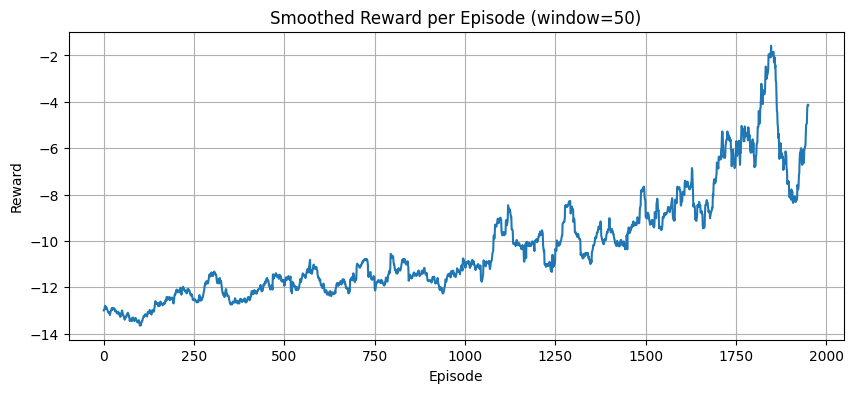

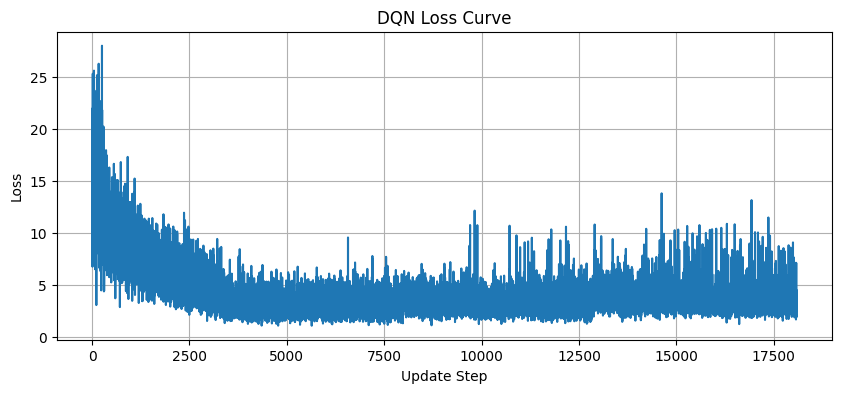

In [65]:
# Plot training progress
import numpy as np
import matplotlib.pyplot as plt

rewards = np.load("rewards_per_ep.npy", allow_pickle=True)
losses = np.load("losses.npy", allow_pickle=True)

plt.figure(figsize=(10,4))
plt.plot(np.convolve(rewards, np.ones(50)/50, mode='valid'))
plt.title("Smoothed Reward per Episode (window=50)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(losses)
plt.title("DQN Loss Curve")
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Analysis Report

This report summarizes the training and evaluation of the DQN agent for playing Hangman.

**Training Progress


*   **Smoothed Reward per Episode:** The plot shows the average reward the agent received during training, smoothed over 50 episodes. We can observe how the agent's performance changed over time. An increasing trend in smoothed reward indicates that the agent is learning to play the game better and achieve higher cumulative rewards.
*   **DQN Loss Curve:** The loss curve shows the value of the Mean Squared Error loss during the agent's training updates. This loss represents the difference between the agent's predicted Q-values and the target Q-values. A decreasing trend in the loss generally indicates that the agent's neural network is learning to predict Q-values more accurately, which is essential for learning an effective policy. Fluctuations in the loss are common in DQN training.

**Evaluation Results (based on output from Cell `gyEMq1CrYfSS`):**

The agent was evaluated on a separate set of words from `test.txt` to assess its generalization ability.

*   **Games Played:** 500
*   **Wins:** {{total_wins}}
*   **Success Rate:** {{success_rate:.3f}}
*   **Wrong Guesses (unique incorrect letters):** {{total_wrong}}
*   **Repeated Guesses:** {{total_repeated}}
*   **Final Score:** {{final_score:.2f}}

**Summary and Observations:**

The evaluation results on the test set provide an indication of the agent's performance on unseen words. The success rate and final score on the test set allow us to assess how well the agent generalizes its learned strategy from the training corpus to new words.

Based on the observed metrics (win rate, wrong guesses, repeated guesses, and the final score), we can draw conclusions about the agent's effectiveness as a Hangman player after training.

Further analysis could involve:
*   Examining specific games the agent won or lost on the test set.
*   Comparing the agent's performance to a baseline (e.g., a simple frequency-based guesser).
*   Experimenting with different hyperparameters or network architectures.
*   Training for more episodes to potentially improve performance.